## 1 準備

In [ ]:
# ライブラリのインポート
import random

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline
# 可視化のためにTensorBoardを用いるので, Colab上でTensorBoardを表示するための宣言を行う
%load_ext tensorboard

In [ ]:
# torch.deviceを定義
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

## 2 環境
スイカ割り環境を使う。

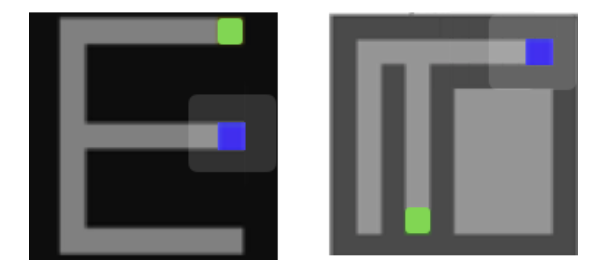

環境は上の図のようなものである。**話し手（画面外）**はマップ全体を見ることができるが、**聞き手（青）**は各方向のピクセルしか見ることができない。各ゲームの開始時に、**旗（緑）**が2つの経路のうちの1つにランダムに配置される。聞き手が正しい通路を選んで旗を見つけることができれば、話し手と聞き手の両方が報酬を受け取ることができる。とりあえず、左をグリッドA、右をグリッドBとし、9×9で実装する。

In [ ]:
class State():

    def __init__(self, row=-1, column=-1):
        self.row = row
        self.column = column

    def __repr__(self):
        return "<State: [{}, {}]>".format(self.row, self.column)

    def clone(self):
        return State(self.row, self.column)

    def __hash__(self):
        return hash((self.row, self.column))

    def __eq__(self, other):
        return self.row == other.row and self.column == other.column

In [ ]:
from typing import Optional, List, Tuple 


class SuikawariEnv:
    """ Suikawari Grid World Environment for Multi-agents
    The background of the field is represented as '0' (White)
    Suikas are represented as '1' (Green)
    The agents are represented as '2' or Int 
        greater than 2 and up to 5. (Red, Blue, Yellow, Magenta)
    """
    UP = 0
    DOWN = 2
    LEFT = 1
    RIGHT = 3
    ACTIONS = [UP, DOWN, LEFT, RIGHT]

    FIELD = 0
    SUIKA = 1
    WALL = 2
    AGENT = 3

    def __init__(self,
                 n_suika: int,
                 n_agents: int,
                 seed: Optional[int] = None,
                 grid_size: int = 9,
                 default_reward: float = -0.04):
        if n_agents > 4:
            raise ValueError('エージェントは4つまで')

        self.config_dict = {
            'n_agents': n_agents,
            'n_suika': n_suika,
            'seed': seed,
            'grid_size': grid_size,
            'default_reward': default_reward,
        }

        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        # Make Suikawari-Grid
        self.n_suika = n_suika
        self.n_agents = n_agents
        self.grid_size = grid_size
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype='int')
        self.grid[:6, 2] = self.WALL
        self.grid[3:, 6] = self.WALL

        # Set Agents' position
        states_cands = [
            State(0, 0),
            State(8, 8),
            State(0, 8),
            State(8, 0),
        ]
        self.states_list = states_cands[:self.n_agents]
        self.defaul_reward = default_reward

        # Set suikas' position
        _suika_pos_cands = np.where(self.grid != self.WALL)
        _id_cands = list(range(_suika_pos_cands[0].shape[0]))
        self.suika_list = []
        while len(self.suika_list) < self.n_suika:
            _id = random.sample(_id_cands, k=1)[0]
            pos_col = _suika_pos_cands[0][_id]
            pos_row = _suika_pos_cands[1][_id]
            if State(pos_row, pos_col) in self.states_list:
                continue
            self.suika_list.append(State(pos_col, pos_row))
            self.grid[pos_col][pos_row] = self.SUIKA

        self.n_got_suika = 0

    @staticmethod
    def clone_states_list(states_list: List[State]):
        return [s.clone() for s in states_list]

    def step(self, action: int,
             agent_id: int) -> Tuple[List[State], float, bool]:
        if agent_id >= self.n_agents:
            raise ValueError("エージェントIDがエージェント数より多い")
        state = self.states_list[agent_id]
        next_state = self._move(state, action)
        if next_state is not None:
            self.states_list[agent_id] = next_state
        reward, done = self._reward_func(next_state)
        return self.states_list, reward, done

    def _move(self, state: State, action) -> State:
        next_state = state.clone()
        # Execute an action (move).
        if action == self.UP:
            next_state.row -= 1
        elif action == self.DOWN:
            next_state.row += 1
        elif action == self.LEFT:
            next_state.column -= 1
        elif action == self.RIGHT:
            next_state.column += 1

        # 端に到達した時はそれ以上移動しない。
        next_state.row = max(next_state.row, 0)
        next_state.row = min(next_state.row, self.grid_size - 1)
        next_state.column = max(next_state.column, 0)
        next_state.column = min(next_state.column, self.grid_size - 1)

        if next_state in self.states_list:
            # 同じ座標のエージェントがすでに存在する場合は移動しない。
            return state
        if self.grid[next_state.row][next_state.column] == self.WALL:
            # 壁にぶつかったときは移動しない
            return state
        return next_state

    def _reward_func(self, state: State) -> Tuple[float, bool]:
        """スイカ割りの進捗に応じて報酬を与える。
        4個中1つ割ったら0.25、もひとつ割ったら0.5のような。
        全て割ったら終了。
        スイカは割られたら消滅する。(セルの値をFIELDに書き換える)
        """
        reward = self.defaul_reward
        done = False

        attribute = self.grid[state.row][state.column]
        if attribute == self.SUIKA:
            self.n_got_suika += 1
            reward = self.n_got_suika / self.n_suika
            self.grid[state.row][state.column] = self.FIELD

        if self.n_got_suika == self.n_suika:
            done = True
        return reward, done

    def reset(self) -> Tuple[np.ndarray, List[State]]:
        self.__init__(**self.config_dict)
        return self.grid, self.states_list

    def observation(self,
                    agent_id: Optional[int] = None,
                    partial: bool = False) -> torch.Tensor:
        assert agent_id is not None if partial else True  #部分観測を得る場合は必ずエージェントを指定する。
        grid = torch.tensor(self.grid)

        # position of reward(suika) cell
        pos_reward = (grid == self.SUIKA)

        # position of wall cell
        pos_wall = (grid == self.WALL)

        # initalize image (shape = (3 (r,g,b), *grid.shape))
        grid_img = torch.ones((*grid.shape, 3)).float()*0.1

        # color
        grid_img[:, :, 1] += pos_reward
        grid_img[:, :, 0] += pos_wall
        grid_img[:, :, 1] += pos_wall
        grid_img[:, :, 2] += pos_wall
        colors = (torch.Tensor([1.0, 0, 0]), torch.Tensor([0, 0, 1.0]),
                  torch.Tensor([1.0, 1.0, 0]), torch.Tensor([1.0, 0, 1.0]))

        for color, state in zip(colors, self.states_list):
            row = state.row
            col = state.column
            grid_img[row, col] = color

        if partial and agent_id is not None:
            state = self.states_list[agent_id]
            row = state.row
            col = state.column
            row_l = max(row - 1, 0)
            row_u = min(row + 2, self.grid_size)
            col_l = max(col - 1, 0)
            col_u = min(col + 2, self.grid_size)
            mask = torch.zeros_like(grid_img)
            mask[row_l:row_u, col_l:col_u, :] = 1.0
            grid_img *= mask
        assert grid_img.shape == (9, 9, 3)
        return grid_img.float()


In [ ]:
env = SuikawariEnv(n_suika=2, n_agents=2)


def one_step(dirction, id):
    states, reward, done = env.step(dirction, agent_id=id)
    im = env.observation(partial=True, agent_id=id)
    print(im.shape)
    # im = env.observation()


one_step(0, 1)
one_step(0, 1)
one_step(0, 1)

## 3 モデル

In [ ]:
# torch.log(0)によるnanを防ぐ
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-8))

# VAEモデルの実装
class VAE_Seq(nn.Module):
    def __init__(self, z_dim):
        super(VAE_Seq, self).__init__()
        # Encoder, xを入力にガウス分布のパラメータmu, sigmaを出力
        self.conv_enc1 = nn.Conv2d(3, 8, 3)
        self.conv_enc2 = nn.Conv2d(8, 16, 3)
        self.dense_encmean = nn.Linear(16*5*5, z_dim)
        self.dense_encvar = nn.Linear(16*5*5, z_dim)

        # Decoder, zを入力にベルヌーイ分布のパラメータlambdaを出力
        self.dense_dec = nn.Linear(z_dim, 16*5*5)
        self.conv_dec1 = nn.ConvTranspose2d(16, 8, 3)
        self.conv_dec2 = nn.ConvTranspose2d(8, 3, 3)
    
    def _encoder(self, x):
        x = F.relu(self.conv_enc1(x))
        x = F.relu(self.conv_enc2(x))
        x = x.view(-1, 16*5*5)
        mean = self.dense_encmean(x)
        std = F.softplus(self.dense_encvar(x))
        return mean, std
    
    def _sample_z(self, mean, std):
        # 再パラメータ化トリック
        epsilon = torch.randn(mean.shape).to(device)
        return mean + std * epsilon
 
    def _decoder(self, z):
        x = F.relu(self.dense_dec(z))
        x = x.view(-1, 16, 5, 5)
        x = F.relu(self.conv_dec1(x))
        # 出力が0~1になるようにsigmoid
        x = torch.sigmoid(self.conv_dec2(x))
        return x

    def forward(self, x):
        mean, std = self._encoder(x)
        z = self._sample_z(mean, std)
        x = self._decoder(z)
        return x, z

    def loss(self, x):
        mean, std = self._encoder(x)
        # KL loss(正則化項)の計算. mean, stdは (batch_size , z_dim)
        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))
    
        z = self._sample_z(mean, std)
        y = self._decoder(z)

        x = x.view(-1, 3*9*9)
        y = y.view(-1, 3*9*9)

        # reconstruction loss(負の再構成誤差)の計算. x, yともに (batch_size , 3*9*9)
        reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=1))
        
        return KL, -reconstruction 

In [ ]:
def entropy(probs):
    # ここのlogをtorch_logにしとく(NaN対策)
    return -torch.sum(probs * torch_log(torch.clamp(probs, min=1e-10)))


class Speaker(nn.Module):
    # 2エージェントでやってみる。
    def __init__(self, m_tokens, m_length, buffer_size=150):
        super(Speaker, self).__init__()
        self.conv_enc1 = nn.Conv2d(3, 8, 3)
        self.conv_enc2 = nn.Conv2d(8, 16, 3)
        self.fc_enc1 = nn.Linear(16 * 5 * 5, 500)
        self.fc_enc2 = nn.Linear(500, m_tokens * m_length)

        self.fc_dec1 = nn.Linear(m_tokens * m_length, 500)
        self.fc_dec2 = nn.Linear(500, 500)
        self.fc_dec3 = nn.Linear(500, 3 * 9 * 9)

        self.speaker_memory = torch.empty((buffer_size, 3, 9, 9),
                                          dtype=torch.float,
                                          device=device)  # x_glbを記憶しておくバッファ
        self._memory_index = 0
        self.buffer_size = buffer_size

        self.m_tokens = m_tokens
        self.m_length = m_length

    def _encoder(self, x):
        h = F.relu(self.conv_enc1(x))
        h = F.relu(self.conv_enc2(h))
        h = h.view(-1, 16 * 5 * 5)
        h = F.relu(self.fc_enc1(h))
        h = self.fc_enc2(h)
        p = h.view(-1, self.m_length, self.m_tokens)
        return p

    def _decoder(self, m):
        m = m.view(-1, self.m_length * self.m_tokens)
        h = F.relu(self.fc_dec1(m))
        h = F.relu(self.fc_dec2(h))
        h = self.fc_dec3(h)
        h = h.view(-1, 3, 9, 9)
        # 出力が0~1になるようにsigmoid
        x = torch.sigmoid(h)
        return x

    def p_to_m(self, p):
        label = torch.argmax(p, dim=-1)
        message = F.one_hot(label, num_classes=self.m_tokens) - p.detach() + p
        return message

    def forward(self, x):
        p = self._encoder(x)
        m = self.p_to_m(p)
        # x_glbを保存
        self.speaker_memory[self._memory_index] = torch.squeeze(x).clone()  
        # リングバッファにする
        self._memory_index = (self._memory_index + 1) % self.buffer_size  
        
        return m

    def loss(self):
        x = self.speaker_memory
        p = self._encoder(x)
        m = self.p_to_m(p)
        y = self._decoder(m)
        return -entropy(torch.mean(p, dim=0)), torch.mean((x - y)**2)


In [ ]:
s = Speaker(m_tokens=2, m_length=10).to(device)
x = env.observation()[None]
x_glb = (env.observation(partial=False)
            .permute(2, 0, 1)
            .reshape(-1, 3, 9, 9)
            .to(device)
         )  # 話し手による全体観測
output = s.forward(x_glb)
print(output.shape)
print(s)
s.loss()

In [ ]:
# actorとcriticのネットワーク（一部の重みを共有しています）
class Controller(nn.Module):
    def __init__(self, z_dim, beta_dim, num_action, hidden_size=200):
        super(Controller, self).__init__()
        num_state = z_dim + beta_dim
        self.fc1 = nn.Linear(num_state, hidden_size) # 状態を入力
        self.fc2a = nn.Linear(hidden_size, num_action)  # actor独自のlayer
        self.fc2c = nn.Linear(hidden_size, 1)  # critic独自のlayer
    
    def forward(self, z, beta):
        x = torch.cat([z, beta], dim=1)
        h = F.elu(self.fc1(x))
        action_prob = F.softmax(self.fc2a(h), dim=-1)
        state_value = self.fc2c(h)
        # 行動選択確率, 状態価値
        return action_prob, state_value

# 統合

In [ ]:
class LWMAgent:
    """LWMのマルチリスナー版
    コンストラクタではあたかも任意のリスナー数を設定できそうだが、Speakerの実装場の都合2まで
    """
    def __init__(self, env, T, n_listeners, num_state=81, z_dim=8,
                 m_tokens=2, m_length=10, beta_dim=20, num_action=4,
                 gamma=0.99, message_prob=0.5, 
                 vae_lr=2e-4, ctrl_lr=4e-4, speaker_lr=5e-5,
                 eps=1e-4, lmd_ent=0.02, lmd_v=0.1):
        super().__init__()
        assert n_listeners == 2
        self.env = env
        self.gamma = gamma  # 割引率
        self.n_listeners = n_listeners
        self.beta_last = None  # 最後にメッセージが送られた時のbetaを保存
        # self.beta_last_list = [None for _ in range(n_listeners)]
        # self.vae = VAE_Seq(z_dim=z_dim).to(device)
        self.vae_list = [
            VAE_Seq(z_dim=z_dim).to(device) for _ in range(n_listeners)
        ]
        # self.controller = Controller(z_dim=z_dim, beta_dim=beta_dim, num_action=num_action).to(device)
        self.controller_list = [
            Controller(z_dim=z_dim, beta_dim=beta_dim,
                       num_action=num_action).to(device)
            for _ in range(n_listeners)
        ]
        self.speaker = Speaker(m_tokens=m_tokens, m_length=m_length).to(device)
        # self.vae_memory = [] # xの記憶(VAEの学習のため)
        self.vae_memory_list = [[] for _ in range(n_listeners)]
        # self.ctrl_memory = []  # （報酬，選択した行動の確率，行動確率, 状態価値, 終了したか）のtupleをlistで保存(Controllerの学習のため)
        self.ctrl_memory_list = [[] for _ in range(n_listeners)]
        self.lmd_ent = lmd_ent  # Controllerのlossにおける、エントロピーによる損失の係数
        self.lmd_v = lmd_v  # Controllerのlossにおける、価値関数のMSEの係数

        self.message_prob = message_prob  # messageが送られる確率
        # オプティマイザの宣言
        lwm_params_list = []
        for _vae, _ctrl in zip(self.vae_list, self.controller_list):
            lwm_params_list.append({'params': _vae.parameters() })
            lwm_params_list.append({'params': _ctrl.parameters(),'lr': ctrl_lr })
        self.lwm_optimizer = torch.optim.Adam(lwm_params_list, lr=vae_lr, eps=eps)
        self.speaker_optimizer = torch.optim.Adam(self.speaker.parameters(),
                                                  lr=speaker_lr,
                                                  eps=eps)

        # スケジューラーの宣言
        self.speaker_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.speaker_optimizer,
            200000,
            eta_min=1e-6,
            last_epoch=-1,
            verbose=False)

    def _calc_listener_loss(self, agent_id):
        # VAEのloss
        vae_memory = self.vae_memory_list[agent_id]
        vae_memory = torch.squeeze(torch.stack(vae_memory))
        if vae_memory.dim() < 4:
            # 次元数が3になるときがある(理由は?)ので、0次元に挿入
            vae_memory = vae_memory[None]
        vae_kl, vae_reconst = self.vae_list[agent_id].loss(vae_memory)
        vae_loss = vae_kl + vae_reconst

        # Actor-CriticでControllerのlossを計算
        R = 0
        actor_loss = 0
        critic_loss = 0
        entropy_loss = 0
        # エピソード内の各ステップの収益を後ろから計算（方策の良さの指標fをR-vとして, 方策勾配で目的関数を最大化していく）
        for r, prob, action_probs, v in self.ctrl_memory_list[agent_id][::-1]:
            R = r + self.gamma * R
            advantage = R - v  # 状態価値関数
            # ここをtorch_logにしとく
            # 負の方策勾配(detach()することでactor側の勾配がcritic側に伝わるのを防ぐ)
            actor_loss -= torch_log(prob) * advantage.detach()  
             # 状態価値関数のloss(元論文ではMSE)
            critic_loss += F.smooth_l1_loss(v, torch.tensor(R).to(device)) 
            # 探索を活発にするための項、最大化したい
            entropy_loss += entropy(action_probs)

        len_ctrl_memory = max(len(self.ctrl_memory_list[agent_id]), 1)
        actor_loss = actor_loss / len_ctrl_memory
        critic_loss = critic_loss / len_ctrl_memory
        entropy_loss = entropy_loss / len_ctrl_memory
        ctrl_loss = actor_loss + self.lmd_v * critic_loss - self.lmd_ent * entropy_loss

        lwm_loss = vae_loss + ctrl_loss

        return lwm_loss, vae_loss, actor_loss, critic_loss, entropy_loss

    # パラメタを更新
    def update(self):
        lwm_loss_list = []
        vae_loss_list = []
        actor_loss_list = []
        critic_loss_list = []
        entropy_loss_list = []
        for listener_id in range(self.n_listeners):
            lwm_loss, vae_loss, actor_loss, critic_loss, entropy_loss = (
                self._calc_listener_loss(listener_id))
            lwm_loss_list.append(lwm_loss)
            vae_loss_list.append(vae_loss)
            actor_loss_list.append(actor_loss)
            critic_loss_list.append(critic_loss)
            entropy_loss_list.append(entropy_loss)

        all_lwm_loss = sum(lwm_loss_list)
        # update listeners' parameters
        self.lwm_optimizer.zero_grad()
        all_lwm_loss.backward()
        self.lwm_optimizer.step()

        # Speaker
        speaker_negent, speaker_rec = self.speaker.loss()
        speaker_loss = speaker_negent + speaker_rec
        self.speaker_optimizer.zero_grad()
        speaker_loss.backward()
        self.speaker_optimizer.step()
        self.speaker_scheduler.step()

        return vae_loss_list, actor_loss_list, critic_loss_list, entropy_loss_list, speaker_negent, speaker_rec

    # softmaxの出力が最も大きい行動を選択（テスト時）
    def get_greedy_action(self, t, env: SuikawariEnv):
        '''
        t : 時刻（=ステップ数）
        state : 聞き手の位置（row, column）
        '''
        # スピーカー x → メッセージm,　信念状態beta
        if t == 0 or np.random.rand() < self.message_prob:  
            # t=0の時にはメッセージが送られ、その後は確率message_probでメッセージが送られる
            x_glb = (env.observation(partial=False)
                        .permute(2, 0, 1)
                        .reshape(-1, 3, 9, 9)
                        .to(device))  # 話し手による全体観測
            m = self.speaker(x_glb)
            m = m.view(1, -1)
            self.beta_last = m
        else:  # メッセージが送られない時
            pass

        # リスナー x → z
        action_list = []
        for listener_id in range(self.n_listeners):
            x_part = (env.observation(agent_id=listener_id, partial=True)
                         .permute(2, 0, 1)
                         .reshape(-1, 3, 9, 9)
                         .to(device))
            _, z = self.vae_list[listener_id](x_part)
            action_prob, _ = self.controller_list[listener_id](z, self.beta_last)
            action = torch.argmax(action_prob.squeeze().data).item()
            action_list.append(action)

        return action_list

    # カテゴリカル分布からサンプリングして行動を選択（学習時）
    def get_action(self, t, env):  
                   # 本当はenvではなくstate(というよりは観測)を渡してあげるコードの方が分かり易い
        '''
        t : 時刻（=ステップ数）
        state : 聞き手の状態State(row, column)
        '''
        # スピーカー x → メッセージm,　信念状態beta
        if t == 0 or np.random.rand() < self.message_prob:  
            # t=0の時にはメッセージが送られ、その後は確率message_probでメッセージが送られる
            x_glb = (env.observation(partial=False)
                        .permute(2, 0, 1)
                        .reshape(-1, 3, 9, 9)
                        .to(device))  # 話し手による全体観測
            m = self.speaker(x_glb)
            m = m.view(1, -1)
            # ここ変えちゃった....
            self.beta_last = m.detach().clone()
        else:  
            # メッセージが送られない時
            pass

        # リスナー x → z
        action_list = []
        selected_action_list = []
        action_prob_list = []
        state_value_list = []
        for listener_id in range(self.n_listeners):
            x_part = env.observation(agent_id=listener_id, partial=True)
            x_part = (x_part.permute(2, 0, 1)
                            .reshape( -1, 3, 9, 9)
                            .to(device))
            self.add_vae_memory(listener_id, x_part)
            reconstruction, z = self.vae_list[listener_id](x_part)
            action_prob, state_value = self.controller_list[listener_id](z, self.beta_last)
            action_prob, state_value = action_prob.squeeze(), state_value.squeeze()
            action = Categorical(action_prob).sample().item()
            action_list.append(action)
            selected_action_list.append(action_prob[action])
            action_prob_list.append(action_prob)
            state_value_list.append(state_value)

        return action_list, selected_action_list, state_value_list, action_prob_list

    def add_vae_memory(self, listener_id, x):
        self.vae_memory_list[listener_id].append(x)

    def add_ctrl_memory(self, listener_id, r, prob, action_prob, v):
        self.ctrl_memory_list[listener_id].append((r, prob, action_prob, v))

    def reset_memory(self, listener_id):
        self.vae_memory_list[listener_id] = []
        self.ctrl_memory_list[listener_id] = []

    def reset_all_memory(self):
        for listener_id in range(self.n_listeners):
            self.reset_memory(listener_id)

    def save(self, dir_name:str, file_name: str):
        for listener_id in range(self.n_listeners):
            torch.save(self.vae_list[listener_id].state_dict(),
                       f'{dir_name}/vae{listener_id}_{file_name}.pth')
            torch.save(self.controller_list[listener_id].state_dict(),
                       f'{dir_name}/controller{listener_id}_{file_name}.pth')
        torch.save(self.speaker.state_dict(),
                    f'{dir_name}/speaker_{file_name}.pth')

## 4 学習

In [ ]:
torch.autograd.set_detect_anomaly(True)
# 各種設定
num_episode = 200000  # 学習エピソード数
T = 28 # エピソードの最大ステップ数
n_suika = 2
n_listeners = 2
env = SuikawariEnv(n_suika=n_suika, n_agents=n_listeners)
agent = LWMAgent(env, T, n_listeners=2) # モデルの定義

# ログ
writer = SummaryWriter(log_dir="./logs") # TensorBoardの設定
test_interval = 100
log_interval = 5000
success_rate = 0
test_success_rate = 0
best_success_rate = 0
t = 0

for episode in tqdm(range(num_episode)):
    env = SuikawariEnv(n_suika=n_suika, n_agents=n_listeners)
    for t in range(T):
        action_list, selected_action_list, state_value_list, action_prob_list = agent.get_action(t, env)  #  行動を選択
        for listener_id in range(n_listeners):
            action = action_list[listener_id]
            prob = selected_action_list[listener_id]
            action_prob = action_prob_list[listener_id]
            state_value = state_value_list[listener_id]
            next_state, reward, done = env.step(action, listener_id)
            agent.add_ctrl_memory(listener_id, reward, prob, action_prob, state_value)
            #　エピソードが終了、エピソードの最大ステップ数に到達したら
            if done or t==T-1:
                if done:
                    success_rate += 1
                vae_loss_list, actor_loss_list, critic_loss_list, entropy_loss_list, speaker_negent, speaker_rec = agent.update()
                agent.reset_all_memory() # パラメタが更新されているので
                break

    # テスト 探索ノイズなしでの性能を評価する
    if (episode + 1) % test_interval == 0:
        env.reset()
        for t in range(T):
            action_list = agent.get_greedy_action(t, env)  #  行動を選択
            for listner_id in range(n_listeners):
                action = action_list[listner_id]

                next_state, reward, done = env.step(action, listner_id)
                #　エピソードが終了、エピソードの最大ステップ数に到達したら
                if done:
                    test_success_rate+=1
                    break
    agent.reset_all_memory()
        
    # 記録する
    writer.add_scalar("t", t, episode+1)
    for listener_id in range(n_listeners):
        writer.add_scalar(f"vae_{listener_id} loss", vae_loss_list[listener_id], episode+1)
        writer.add_scalar(f"actor_{listener_id} loss", actor_loss_list[listener_id], episode+1)
        writer.add_scalar(f"critic_{listener_id} loss", critic_loss_list[listener_id], episode+1)
        writer.add_scalar(f"entropy_{listener_id} loss", entropy_loss_list[listener_id], episode+1)
    writer.add_scalar("speaker negent", speaker_negent.item(), episode+1)
    writer.add_scalar("speaker rec", speaker_rec.item(), episode+1)
    
    if (episode+1) % log_interval == 0:
        success_rate /= log_interval
        test_success_rate /= (log_interval / test_interval)

        writer.add_scalar("success rate", success_rate, episode+1)
        writer.add_scalar("test success rate", test_success_rate, episode+1)

        print("Episode %d finished | Success rate %f" % (episode+1, success_rate))
        print("Episode %d finished | Test success rate %f" % (episode+1, test_success_rate))

        # 重みの保存
        if best_success_rate < test_success_rate:
            agent.save('.', 'best')
            best_success_rate = test_success_rate
        else:
            agent.save('.', 'last')
            best_success_rate = test_success_rate              

        success_rate = 0
        test_success_rate = 0

# writerを閉じる
writer.close()

In [ ]:
%tensorboard --logdir='./logs'

## 5 挙動確認

### 5-1 VAE-Seq

In [ ]:
with torch.no_grad():
    env.reset()
    for _ in range(7):
      env.step(1)
    for _ in range(4):
      env.step(2)
    for _ in range(7):
      env.step(3)
    x_part = env.observation(partial=True)
    print('input')
    plt.imshow(x_part)
    plt.show()
    x_part = x_part.permute(2, 0, 1).reshape(-1, 3, 9, 9).to(device) 
    _, z = agent.vae(x_part)
    x_img = agent.vae._decoder(z).reshape(3, 9, 9).permute(1, 2, 0).cpu().detach().numpy()
    print('output')
    plt.imshow(x_img)
    plt.show()
    agent.reset_memory()